In [9]:
!pip install praw
import praw
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
user_agent = "Brand sentiment analysis"
reddit = praw.Reddit(
  client_id="ujQpmAa-rxhI6tgE246E4w",
  client_secret="BnhybdI_fallhH64Us6vutIfsXP21Q",
  user_agent=user_agent
)

In [10]:
def fetch_reddit_posts(subreddit, query, limit=100):
  subreddit = reddit.subreddit(subreddit)
  posts = []
  for post in subreddit.search(query, limit=limit):
        posts.append([post.created_utc, post.title, post.selftext])
  return pd.DataFrame(posts, columns=["Date", "Title", "Body"])

In [11]:
df_chatgpt = fetch_reddit_posts('all', 'ChatGPT', 100)
df_gemini = fetch_reddit_posts('all', 'Gemini AI', 100)
df_copilot = fetch_reddit_posts('all', 'Copilot AI', 100)

In [15]:
import re

def clean_text(text):
  text = re.sub(r'\s+', ' ', text)
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  return text.lower()

df_chatgpt['Body'] = df_chatgpt['Body'].apply(clean_text)
df_gemini['Body'] = df_gemini['Body'].apply(clean_text)
df_copilot['Body'] = df_copilot['Body'].apply(clean_text)

In [16]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
  return sia.polarity_scores(text)['compound']

df_chatgpt['Sentiment'] = df_chatgpt['Body'].apply(get_sentiment_score)
df_gemini['Sentiment'] = df_gemini['Body'].apply(get_sentiment_score)
df_copilot['Sentiment'] = df_copilot['Body'].apply(get_sentiment_score)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/syahrezapratama/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [17]:
print("ChatGPT Sentiment Statistics:")
print(df_chatgpt['Sentiment'].describe())

print("Gemini AI Sentiment Statistics:")
print(df_gemini['Sentiment'].describe())

print("Copilot AI Sentiment Statistics:")
print(df_copilot['Sentiment'].describe())


ChatGPT Sentiment Statistics:
count    100.000000
mean       0.103244
std        0.307593
min       -0.704800
25%        0.000000
50%        0.000000
75%        0.000000
max        0.993200
Name: Sentiment, dtype: float64
Gemini AI Sentiment Statistics:
count    100.000000
mean       0.110594
std        0.372494
min       -0.999100
25%        0.000000
50%        0.000000
75%        0.000000
max        0.986700
Name: Sentiment, dtype: float64
Copilot AI Sentiment Statistics:
count    100.000000
mean       0.150725
std        0.375058
min       -0.742500
25%        0.000000
50%        0.000000
75%        0.000000
max        0.998100
Name: Sentiment, dtype: float64


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


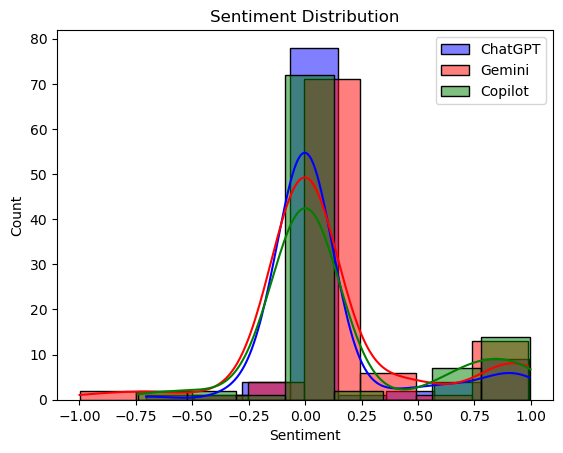

In [18]:
sns.histplot(df_chatgpt['Sentiment'], kde=True, label='ChatGPT', color='blue')
sns.histplot(df_gemini['Sentiment'], kde=True, label='Gemini', color='red')
sns.histplot(df_copilot['Sentiment'], kde=True, label='Copilot', color='green')
plt.legend()
plt.title('Sentiment Distribution')
plt.show()
